# Spark Basics

In [34]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.ml.stat as ml_stat
import pyspark.sql.functions as func
import pyspark.sql.types as types
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [35]:
spark = SparkSession.builder.appName('Spark Test App').getOrCreate() 
sc = spark.sparkContext
spark

**Spark** is a **distributed programming model** where the user specifies **transformations**, which build up a directed-acyclic-graph of instructions, and **actions**, which begin the process of executing that graph of instructions, as a single job, by breaking it down into stages and tasks to execute across the cluster. The way we store data on which to perform transformations and actions are **DataFrames** and Datasets. To create a new DataFrame or Dataset, you call a transformation. To start computation or convert to native language types, you call an action.

### Most basic structures: RDDs

RDDs are just the internal representation of spark data structures and rarely used directly. Normally one should work on dataframes instead (see below).

In [36]:
rdd = sc.parallelize(range(100))

In [37]:
rdd.take(5)

[0, 1, 2, 3, 4]

In [38]:
rdd.count()

100

In [39]:
rdd.sum()

4950

In [40]:
rdd.map(lambda x: x*x).take(5)

[0, 1, 4, 9, 16]

In [41]:
rdd.reduce(lambda a,b: a+b)

4950

In [42]:
rdd.filter(lambda x: 50<x<75).sum()

1500

### Spark DataFrames

Definitionally, a **DataFrame** consists of a series of **records** (like rows in a table), that are of **type Row**, and a number of columns (like columns in a spreadsheet) that represent an computation expression that can performed on each individual record in the dataset. The **schema** defines the name as well as the type of data in each column. The partitioning of the DataFrame defines the layout of the DataFrame or Dataset’s physical distribution across the cluster. The partitioning scheme defines how that is broken up, this can be set to be based on values in a certain column or non-deterministically.

In [43]:
# Create df from rows (only column names are here supplied as schema, types are inferred)
emp = spark.createDataFrame([
    ('1', 'Joe', '70000', '1'),
    ('2', 'Henry', '80000', '2'),
    ('3', 'Sam',   '60000', '2')],
    schema=['Id', 'Name', 'Sallary','DepartmentId']
)
emp.show()

+---+-----+-------+------------+
| Id| Name|Sallary|DepartmentId|
+---+-----+-------+------------+
|  1|  Joe|  70000|           1|
|  2|Henry|  80000|           2|
|  3|  Sam|  60000|           2|
+---+-----+-------+------------+



In [44]:
# Create df from columns
x=[1,2,3,4,5,6,7,8,9,10]
y=[7,6,5,4,5,6,7,8,9,10]
df_test = spark.createDataFrame(zip(x,y), ['val1', 'val2'])
df_test.show()

+----+----+
|val1|val2|
+----+----+
|   1|   7|
|   2|   6|
|   3|   5|
|   4|   4|
|   5|   5|
|   6|   6|
|   7|   7|
|   8|   8|
|   9|   9|
|  10|  10|
+----+----+



In [81]:
# Create df with one id column and range of integers
df_id=spark.range(1,11)
df_id.show()

+---+
| id|
+---+
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
| 10|
+---+



In [46]:
df_id.rdd.getNumPartitions()

4

In [47]:
# Create DF from a csv file (without schema)
df_auto = spark.read.csv('Auto.csv', header=True)
df_auto.show(5)

+---+---------+------------+----------+------+------------+----+------+--------------------+
|mpg|cylinders|displacement|horsepower|weight|acceleration|year|origin|                name|
+---+---------+------------+----------+------+------------+----+------+--------------------+
| 18|        8|         307|       130|  3504|          12|  70|     1|chevrolet chevell...|
| 15|        8|         350|       165|  3693|        11.5|  70|     1|   buick skylark 320|
| 18|        8|         318|       150|  3436|          11|  70|     1|  plymouth satellite|
| 16|        8|         304|       150|  3433|          12|  70|     1|       amc rebel sst|
| 17|        8|         302|       140|  3449|        10.5|  70|     1|         ford torino|
+---+---------+------------+----------+------+------------+----+------+--------------------+
only showing top 5 rows



In [87]:
# Alternative way to provide options
df_auto = (spark
           .read
           .option("header", True)
           .csv('Auto.csv')
)
df_auto.show(5)

+---+---------+------------+----------+------+------------+----+------+--------------------+
|mpg|cylinders|displacement|horsepower|weight|acceleration|year|origin|                name|
+---+---------+------------+----------+------+------------+----+------+--------------------+
| 18|        8|         307|       130|  3504|          12|  70|     1|chevrolet chevell...|
| 15|        8|         350|       165|  3693|        11.5|  70|     1|   buick skylark 320|
| 18|        8|         318|       150|  3436|          11|  70|     1|  plymouth satellite|
| 16|        8|         304|       150|  3433|          12|  70|     1|       amc rebel sst|
| 17|        8|         302|       140|  3449|        10.5|  70|     1|         ford torino|
+---+---------+------------+----------+------+------------+----+------+--------------------+
only showing top 5 rows



In [48]:
# No schema -> all variables strings
df_auto.printSchema()

root
 |-- mpg: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- displacement: string (nullable = true)
 |-- horsepower: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- acceleration: string (nullable = true)
 |-- year: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- name: string (nullable = true)



### DataFrame Schemas

In [49]:
# Create Data Frame from a csv file with inferred schema
df_auto = spark.read.csv('Auto.csv', header=True, inferSchema=True)
df_auto.show(5)

+----+---------+------------+----------+------+------------+----+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|year|origin|                name|
+----+---------+------------+----------+------+------------+----+------+--------------------+
|18.0|        8|       307.0|       130|  3504|        12.0|  70|     1|chevrolet chevell...|
|15.0|        8|       350.0|       165|  3693|        11.5|  70|     1|   buick skylark 320|
|18.0|        8|       318.0|       150|  3436|        11.0|  70|     1|  plymouth satellite|
|16.0|        8|       304.0|       150|  3433|        12.0|  70|     1|       amc rebel sst|
|17.0|        8|       302.0|       140|  3449|        10.5|  70|     1|         ford torino|
+----+---------+------------+----------+------+------------+----+------+--------------------+
only showing top 5 rows



In [50]:
# Now variable types are inferred
df_auto.printSchema()

root
 |-- mpg: double (nullable = true)
 |-- cylinders: integer (nullable = true)
 |-- displacement: double (nullable = true)
 |-- horsepower: string (nullable = true)
 |-- weight: integer (nullable = true)
 |-- acceleration: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- origin: integer (nullable = true)
 |-- name: string (nullable = true)



In [51]:
# How schema is modelled
df_auto.schema

StructType(List(StructField(mpg,DoubleType,true),StructField(cylinders,IntegerType,true),StructField(displacement,DoubleType,true),StructField(horsepower,StringType,true),StructField(weight,IntegerType,true),StructField(acceleration,DoubleType,true),StructField(year,IntegerType,true),StructField(origin,IntegerType,true),StructField(name,StringType,true)))

A schema is a **StructType** made up of a number of fields, **StructFields**, that have a name, type, and a boolean flag which specifies whether or not that column can contain missing or null values.

In [52]:
# Define a manual schema
my_schema = types.StructType([
    types.StructField('mpg', types.FloatType(), True),
    types.StructField('cylinders', types.ByteType(), True),
    types.StructField('displacement', types.FloatType(), True),
    types.StructField('horsepower', types.FloatType(), True),
    types.StructField('weight', types.FloatType(), True),
    types.StructField('acceleration', types.FloatType(), True),
    types.StructField('year', types.ByteType(), True),
    types.StructField('origin', types.ByteType(), True),
    types.StructField('name', types.StringType(), True),
])

In [53]:
# Read data with manual schema
df_auto = spark.read.csv('Auto.csv', header=True, schema=my_schema)
df_auto.show(5)

+----+---------+------------+----------+------+------------+----+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|year|origin|                name|
+----+---------+------------+----------+------+------------+----+------+--------------------+
|18.0|        8|       307.0|     130.0|3504.0|        12.0|  70|     1|chevrolet chevell...|
|15.0|        8|       350.0|     165.0|3693.0|        11.5|  70|     1|   buick skylark 320|
|18.0|        8|       318.0|     150.0|3436.0|        11.0|  70|     1|  plymouth satellite|
|16.0|        8|       304.0|     150.0|3433.0|        12.0|  70|     1|       amc rebel sst|
|17.0|        8|       302.0|     140.0|3449.0|        10.5|  70|     1|         ford torino|
+----+---------+------------+----------+------+------------+----+------+--------------------+
only showing top 5 rows



In [54]:
df_auto.printSchema()

root
 |-- mpg: float (nullable = true)
 |-- cylinders: byte (nullable = true)
 |-- displacement: float (nullable = true)
 |-- horsepower: float (nullable = true)
 |-- weight: float (nullable = true)
 |-- acceleration: float (nullable = true)
 |-- year: byte (nullable = true)
 |-- origin: byte (nullable = true)
 |-- name: string (nullable = true)



### Different ways to refer to a column

In [82]:
df_auto["mpg"]

Column<b'mpg'>

In [84]:
df_auto.mpg

Column<b'mpg'>

In [85]:
func.col("mpg")

Column<b'mpg'>

In [86]:
func.expr("mpg")

Column<b'mpg'>

### Convert between Spark and Pandas Dataframes

In [55]:
df_ad=pd.read_csv('Advertising.csv')
df_ad.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [56]:
dfs = spark.createDataFrame(df_ad)
dfs.show(5)

+----------+-----+-----+---------+-----+
|Unnamed: 0|   TV|Radio|Newspaper|Sales|
+----------+-----+-----+---------+-----+
|         1|230.1| 37.8|     69.2| 22.1|
|         2| 44.5| 39.3|     45.1| 10.4|
|         3| 17.2| 45.9|     69.3|  9.3|
|         4|151.5| 41.3|     58.5| 18.5|
|         5|180.8| 10.8|     58.4| 12.9|
+----------+-----+-----+---------+-----+
only showing top 5 rows



In [57]:
dfs.toPandas().head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


### SQL Queries on Spark Dataframes

In [58]:
# Create temporary view from dataframe
df_auto.createOrReplaceTempView('view_auto')
# SQL Query on the view
df_result=spark.sql('select * from view_auto where mpg>40')
df_result.show()

+----+---------+------------+----------+------+------------+----+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|year|origin|                name|
+----+---------+------------+----------+------+------------+----+------+--------------------+
|43.1|        4|        90.0|      48.0|1985.0|        21.5|  78|     2|volkswagen rabbit...|
|41.5|        4|        98.0|      76.0|2144.0|        14.7|  80|     2|           vw rabbit|
|46.6|        4|        86.0|      65.0|2110.0|        17.9|  80|     3|           mazda glc|
|40.8|        4|        85.0|      65.0|2110.0|        19.2|  80|     3|          datsun 210|
|44.3|        4|        90.0|      48.0|2085.0|        21.7|  80|     2|vw rabbit c (diesel)|
|43.4|        4|        90.0|      48.0|2335.0|        23.7|  80|     2|  vw dasher (diesel)|
|44.6|        4|        91.0|      67.0|1850.0|        13.8|  80|     3| honda civic 1500 gl|
|44.0|        4|        97.0|      52.0|2130.0|        24.6|

In [59]:
# Get execution plan of the query
df_result.explain()

== Physical Plan ==
*(1) Project [mpg#491, cylinders#492, displacement#493, horsepower#494, weight#495, acceleration#496, year#497, origin#498, name#499]
+- *(1) Filter (isnotnull(mpg#491) && (mpg#491 > 40.0))
   +- *(1) FileScan csv [mpg#491,cylinders#492,displacement#493,horsepower#494,weight#495,acceleration#496,year#497,origin#498,name#499] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/Users/andreas/Desktop/Materialien/Spark/Auto.csv], PartitionFilters: [], PushedFilters: [IsNotNull(mpg), GreaterThan(mpg,40.0)], ReadSchema: struct<mpg:float,cylinders:tinyint,displacement:float,horsepower:float,weight:float,acceleration:...


In [60]:
df_result.collect()

[Row(mpg=43.099998474121094, cylinders=4, displacement=90.0, horsepower=48.0, weight=1985.0, acceleration=21.5, year=78, origin=2, name='volkswagen rabbit custom diesel'),
 Row(mpg=41.5, cylinders=4, displacement=98.0, horsepower=76.0, weight=2144.0, acceleration=14.699999809265137, year=80, origin=2, name='vw rabbit'),
 Row(mpg=46.599998474121094, cylinders=4, displacement=86.0, horsepower=65.0, weight=2110.0, acceleration=17.899999618530273, year=80, origin=3, name='mazda glc'),
 Row(mpg=40.79999923706055, cylinders=4, displacement=85.0, horsepower=65.0, weight=2110.0, acceleration=19.200000762939453, year=80, origin=3, name='datsun 210'),
 Row(mpg=44.29999923706055, cylinders=4, displacement=90.0, horsepower=48.0, weight=2085.0, acceleration=21.700000762939453, year=80, origin=2, name='vw rabbit c (diesel)'),
 Row(mpg=43.400001525878906, cylinders=4, displacement=90.0, horsepower=48.0, weight=2335.0, acceleration=23.700000762939453, year=80, origin=2, name='vw dasher (diesel)'),
 Ro

In [61]:
# Get all car names from result
[row.name for row in df_result.collect()]

['volkswagen rabbit custom diesel',
 'vw rabbit',
 'mazda glc',
 'datsun 210',
 'vw rabbit c (diesel)',
 'vw dasher (diesel)',
 'honda civic 1500 gl',
 'vw pickup']

In [62]:
# Get all car names from result (using rdds)
df_result.rdd.map(lambda row: row.name).collect()

['volkswagen rabbit custom diesel',
 'vw rabbit',
 'mazda glc',
 'datsun 210',
 'vw rabbit c (diesel)',
 'vw dasher (diesel)',
 'honda civic 1500 gl',
 'vw pickup']

### Basic Statistics

In [63]:
# read some test data
df = spark.read.parquet('hmp.parquet')
df.show()

+---+---+---+--------------------+-----------+
|  x|  y|  z|              source|      class|
+---+---+---+--------------------+-----------+
| 22| 49| 35|Accelerometer-201...|Brush_teeth|
| 22| 49| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|
| 21| 52| 34|Accelerometer-201...|Brush_teeth|
| 22| 51| 34|Accelerometer-201...|Brush_teeth|
| 20| 50| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 34|Accelerometer-201...|Brush_teeth|
| 22| 50| 34|Accelerometer-201...|Brush_teeth|
| 22| 51| 35|Accelerometer-201...|Brush_teeth|
| 21| 51| 33|Accelerometer-201...|Brush_teeth|
| 20| 50| 34|Accelerometer-201...|Brush_teeth|
| 21| 49| 33|Accelerometer-201...|Brush_teeth|
| 21| 49| 33|Accelerometer-201...|Brush_teeth|
| 20| 51| 35|Accelerometer-201...|Brush_teeth|
| 18| 49| 34|Accelerometer-201...|Brush_teeth|
| 19| 48| 34|Accelerometer-201...|Brush_teeth|
| 16| 53| 34|Accelerometer-201...|Brush_teeth|
| 18| 52| 35|

In [64]:
df.count()

446529

In [65]:
# register a corresponding query table
df.createOrReplaceTempView('df')

In [66]:
class_counts=spark.sql('select class, count(*) as count from df group by class')
class_counts.show()

+--------------+-----+
|         class|count|
+--------------+-----+
| Use_telephone|15225|
| Standup_chair|25417|
|      Eat_meat|31236|
|     Getup_bed|45801|
|   Drink_glass|42792|
|    Pour_water|41673|
|     Comb_hair|23504|
|          Walk|92254|
|  Climb_stairs|40258|
| Sitdown_chair|25036|
|   Liedown_bed|11446|
|Descend_stairs|15375|
|   Brush_teeth|29829|
|      Eat_soup| 6683|
+--------------+-----+



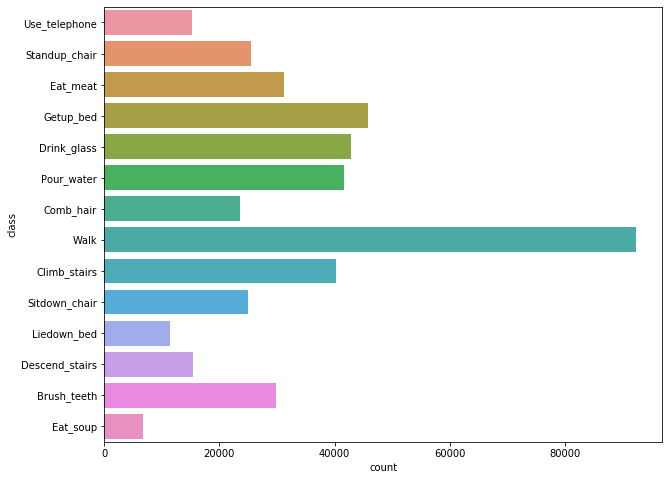

In [67]:
# Bar chart with seaborn
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.barplot(y='class', x='count', data=class_counts.toPandas())

In [68]:
# Compute some stat measures using sql
spark.sql('''
    select class, 
        mean(z) as mean,
        stddev(z) as stddev,
        skewness(z) as skewness,
        kurtosis(z) as kurtosis
    from df
    group by class

''').show()

+--------------+------------------+------------------+--------------------+--------------------+
|         class|              mean|            stddev|            skewness|            kurtosis|
+--------------+------------------+------------------+--------------------+--------------------+
| Use_telephone| 46.38108374384237| 4.513241393892794| -0.5131233366074077| 0.17798176092970408|
| Standup_chair| 41.06129755675335| 8.368604531264426| 0.09372062335788772| -1.3273653838881427|
|      Eat_meat|50.732168011269046|2.8486012596744095| -1.9229950246195278|   3.901203742638093|
|     Getup_bed| 42.50450863518264|  8.25752180457239| -0.5010453424041553|-0.00492869537061...|
|   Drink_glass| 49.08013180033651| 2.939888478378836| -0.9003736116594014|  1.4612650215915384|
|    Pour_water| 49.32512658075972|  3.44048855657184|  -1.315827893589405|   3.110667397244592|
|     Comb_hair|  43.3518975493533|7.7823498077618085|-0.05636554300821405| -0.0779550994629914|
|          Walk|35.59096624536

In [69]:
df.select(['x', 'y', 'z']).describe().show()

+-------+------------------+-----------------+-----------------+
|summary|                 x|                y|                z|
+-------+------------------+-----------------+-----------------+
|  count|            446529|           446529|           446529|
|   mean|24.671555486877672|38.21949078335338|41.83984242904716|
| stddev| 12.15759300618102|7.690688487231707|8.303435899413733|
|    min|                 0|                0|                0|
|    max|                63|               63|               63|
+-------+------------------+-----------------+-----------------+



In [70]:
# Correlation
x=[1,2,3,4,5,6,7,8,9,10]
y=[7,6,5,4,5,6,7,8,9,10]
df_test = spark.createDataFrame(zip(x,y), ['val1', 'val2'])
df_test.corr('val1', 'val2')

0.7092729120837249

In [71]:
# Covariance
df_test.cov('val1', 'val2')

4.055555555555555

In [73]:
# Skewness as spark function
x=[34,1,23,4,3,3,12,4,3,1]
df_test = spark.createDataFrame(pd.DataFrame(x, columns=['val']))
df_test.select(func.skewness(df_test.val)).show()

+---------------+
|  skewness(val)|
+---------------+
|1.4549069329914|
+---------------+



### Safe data as parquet format

In [75]:
df_auto.show()

+----+---------+------------+----------+------+------------+----+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|year|origin|                name|
+----+---------+------------+----------+------+------------+----+------+--------------------+
|18.0|        8|       307.0|     130.0|3504.0|        12.0|  70|     1|chevrolet chevell...|
|15.0|        8|       350.0|     165.0|3693.0|        11.5|  70|     1|   buick skylark 320|
|18.0|        8|       318.0|     150.0|3436.0|        11.0|  70|     1|  plymouth satellite|
|16.0|        8|       304.0|     150.0|3433.0|        12.0|  70|     1|       amc rebel sst|
|17.0|        8|       302.0|     140.0|3449.0|        10.5|  70|     1|         ford torino|
|15.0|        8|       429.0|     198.0|4341.0|        10.0|  70|     1|    ford galaxie 500|
|14.0|        8|       454.0|     220.0|4354.0|         9.0|  70|     1|    chevrolet impala|
|14.0|        8|       440.0|     215.0|4312.0|         8.5|

In [76]:
df_auto.rdd.getNumPartitions()

1

In [77]:
df_auto2=df_auto.repartition(4)
df_auto2.rdd.getNumPartitions()

4

In [78]:
# File distributed in 4 partitions
df_auto2.write.parquet("auto.parquet")

In [79]:
# Save file in one partition
df_auto2.coalesce(1).write.parquet("auto_one.parquet")